# <span style="color:green">**Clasificación de Datos MOCAP**</span>

**Estudiante:** <span style="color:blue">Mario García Moncayo </span>
**Director:** <span style="color:blue">Cristhian Kaori Valencia </span>
        
**Fecha:**   <span style="color:blue">22 de abril del 2024</span> 

CLASIFICACIÓN DE DATOS MOCAP SOBRE UNA DISCIPLINA DEPORTIVA USANDO MODELOS DE MACHINE LEARNING


In [1]:
#!pip install pymo

## <span style="color:blue">**Importar librerías** </span>

Traemos la carpeta **PYMO** previamente descargada en el ordenador local del URL: https://github.com/omimo/PyMO
y copiamos los archivos en la ruta de anaconda-jupyter, para hacer uso de los contenidos y parámetros de la misma, aparte cargamos los demás paquetes que vamos a usar

In [2]:
#Load packages
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import pickle
import timeit
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import os
import scipy.io as sio
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.base import  BaseEstimator, TransformerMixin, ClassifierMixin
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import warnings
warnings.filterwarnings("ignore")

## <span style="color:blue">**Importar SHECCO** </span>
Clase principal correspondiente al cálculo de la métrica SHECCO descargada del URL: https://github.com/Ckvalencia/hello-world/blob/master/SHECCO_CMU_sub.ipynb

In [3]:

#clase principal shecco
class SHECCO(BaseEstimator,TransformerMixin):
    def __init__(self, sigmax = 54, sigmay = 54, Ax = 1, Ay = 1,ws = 5, noverlap = None, k = 50, sup = 1):
        self.sigmax = sigmax
        self.sigmay = sigmay
        self.ws = ws
        self.noverlap = noverlap
        self.sup = sup
        self.k = k
        self.Ax = Ax
        self.Ay = Ay
        
##################################################################

    def plot_mocap(self, Ns, Nv, ind):
     mp_p = MocapParameterizer(param_type = 'position')
     data_all = [p.parse('D:/Escritorio/datos_mocap/'+Ns+'/'+list_folder[Nv])]
     pos_d= mp_p.fit_transform(data_all)
     #Normalization
     n=pos_d[0].values
     P = np.asarray(pos_d[0].values)
     z = P.reshape(n.shape[0],38,3)
     Z = np.zeros(z.shape)
     for i in range(z.shape[0]):
       for j in range(z.shape[1]):
         Z[i,j,:] =z[i,j,:]- z[i,0,:]       
    
     print(f"Shape of ind: {ind.shape}")
     print(f"Shape of Z: {Z.shape}")
    
     #Distance among skeletons
     for k in range(ind.shape[0]):
       for l in range(Z.shape[1]):
         Z[ind[k],l,0]= Z[ind[k],l,0]+20*k
     Z = Z.reshape(n.shape[0],114)
     n.iloc[:]=Z[:]
     pos_d[0].values = n

     if ind.shape[0]<= 10:
       draw_stickfigure(pos_d[0], frame = ind, figsize=(20,4))
     else: 
       nf = int(ind.shape[0]/10)
       for h in range(0,nf):
         draw_stickfigure(pos_d[0], frame = ind[10*h:10*(h+1)], figsize=(20,4))
         plt.show()

########################################

    def geneout_(self,X):
      #print(X.shape)
      N,T = X.shape
      Y = np.zeros((N,T))
      for n in range(N):
        for t in range(T-1):
          Y[n,t]=X[n,t+1]
      return Y

    def ventaneo_(self,X):
       N,P = X.shape
       if self.noverlap == None: self.noverlap =0
       if self.ws == None: self.ws = P
       for j in range(N):
         pi = 0
         pf = self.ws
         Xi = X[j,pi:pf].reshape(1,-1) 
         Yi = X[j,pf].reshape(1,-1)
         pi = pi + (self.ws - self.noverlap)
         pf = pi +self.ws
         while pf  < P:
                Xi = np.r_[Xi,X[j,pi:pf].reshape(1,-1)]
                Yi = np.r_[Yi,X[j,pf].reshape(1,-1)]
                pi = pi + (self.ws - self.noverlap)
                pf = pi +self.ws
                #print(Xi,Yi)
         #print(pi,pf)
         if pf >= P:
            temp = X[j,pi:].reshape(1,-1)
            Xi = np.r_[Xi,np.c_[temp,np.zeros(self.ws-temp.shape[1]).reshape(1,-1)]]
            Yi = np.r_[Yi,np.zeros(1).reshape(-1,1)]       
         if j == 0: 
           #print(Xi.shape)
           X_ = np.zeros((N,Xi.shape[0],Xi.shape[1]))
           Y_ = np.zeros((N,Yi.shape[0],1))
         X_[j] = Xi  
         Y_[j] = Yi  
       return X_,Y_  

    def SC_(self,X,Y):
        Xcl = np.zeros((X.shape[0], self.k))
        Ycl = np.zeros((Y.shape[0], self.k))
        for n in range(X.shape[0]):
            Z = X[n]
            L = Y[n]
            Z = np.tile(Z,(Z.shape[0],1))
            D = pairwise_distances(Z,Z)
            gamma = 1/(np.median(D)**2)
            K = np.exp(-0.5*gamma*D**2)
            Clus = SpectralClustering(n_clusters= self.k,affinity='precomputed')
            y_pred = Clus.fit_predict(K)
            centers = np.zeros((self.k,Z.shape[1]))
            for c in range(self.k):
                centers[c] = Z[y_pred==c].mean(axis=0)
                
            Ds = pairwise_distances(centers,Z)
            ind = np.argmin(Ds,axis=1) 
            Xcl[n] = Z[ind]
            Ycl[n] = L[ind]
        return Xcl,Ycl

    def SC_Mocap(self,X,Y):
      Xcl = np.zeros((self.k, X.shape[1]))
      Ycl = np.zeros((self.k, Y.shape[1]))
      D = pairwise_distances(Y,Y)
      gamma = 1/(np.median(D)**2)
      K = np.exp(-0.5*gamma*D**2)
      Clus = SpectralClustering(n_clusters= self.k,affinity='precomputed')
      y_pred = Clus.fit_predict(K)
      centers = np.zeros((self.k,Y.shape[1]))
      for c in range(self.k):
        centers[c] = Y[y_pred==c].mean(axis=0)

      Ds = pairwise_distances(centers,Y)
      ind = np.argmin(Ds,axis=1)
      Xcl = X[ind]
      Ycl = Y[ind]
      return Xcl,Ycl,ind


    def Kmeans_Mocap(self,X):
      Xcl = np.zeros((self.k, X.shape[1]))
      #Ycl = np.zeros((self.k, Y.shape[1]))
      #Clus = KMeans(n_clusters= self.k, random_state=0)
      y_pred = KMeans(n_clusters= self.k, random_state=0).fit_predict(X)
      centers = np.zeros((self.k,X.shape[1]))
      for c in range(self.k):
        centers[c] = X[y_pred==c].mean(axis=0)

      Ds = pairwise_distances(centers,X)
      ind = np.argmin(Ds,axis=1)
      Xcl = X[ind]
      #Ycl = Y[ind]
      return Xcl,ind

    def kergM(self,X,Y,sigma_,A):
       return A*np.exp(-pairwise_distances(X,Y)**2/(2*sigma_**2))
    
    def shecco_(self,X,Y,Z,L,pxx,pyy,pzz,pll,pxz=None,pyl=None):  
      #se asume independencia
     
      if (pxz==None) & (pyl==None):
          PXX = pxx.reshape(-1,1)#.dot(pxx.reshape(1,-1))
          PYY = pyy.reshape(-1,1)#.dot(pyy.reshape(1,-1))  
          PZZ = pzz.reshape(-1,1)#.dot(pzz.reshape(1,-1))  
          PLL = pll.reshape(-1,1)#.dot(pll.reshape(1,-1))  
          PXY = pxx.reshape(-1,1)#.dot(pyy.reshape(1,-1))  
          PZL = pzz.reshape(-1,1)#.dot(pll.reshape(1,-1))  
      KXX  = self.kergM(X,X,self.sigmax,self.Ax)
      KZZ  = self.kergM(Z,Z,self.sigmax,self.Ax)
      KYY  = self.kergM(Y,Y,self.sigmay,self.Ay)
      KLL  = self.kergM(L,L,self.sigmay,self.Ay)
      KXZ  = self.kergM(X,Z,self.sigmax,self.Ax)
      KYL  = self.kergM(Y,L,self.sigmay,self.Ay)


      #trxx=KXX.shape[0]**2 #np.sqrt(np.trace((KXX.dot(KXX))))
  
      #trzz=KZZ.shape[0]**2#np.sqrt(np.trace((KZZ.dot(KZZ))))
    
      #tryy=KYY.shape[0]**2#np.sqrt(np.trace((KYY.dot(KYY))))
     
      #trll=KLL.shape[0]**2#np.sqrt(np.trace((KLL.dot(KLL))))
    
      #trxz=KXX.shape[0]*KZZ.shape[0]#np.sqrt(np.trace((KXZ.dot(KXZ.T))))
     
      #tryl=KYY.shape[0]*KLL.shape[0]#np.sqrt(np.trace((KYL.dot(KYL.T))))
      #KXX = KXX*trxx
      #KZZ = KZZ*trzz
      #KYY = KYY*tryy
      #KLL = KLL*trll
      #KXZ = KXZ*trxz
      #KYL = KYL*tryl

   # Distancia     
      #d = np.trace((PXX*KXX).dot(KYY*PYY)) -2*np.trace((PXZ*KXZ).dot((KYL*PYL).T)) + np.trace((PZZ*KZZ).dot(KLL*PLL))
      d = (PXY.T).dot(KXX*KYY).dot(PXY) -2*(PXY.T).dot(KXZ*KYL).dot(PZL) + (PZL.T).dot(KZZ*KLL).dot(PZL)

      if d<0:
        d = abs(d)
      return d

    #hecco sin salida (no supervised)
    def hecco_(self,X,Z,pxx,pzz,pxz=None,pyl=None):  
      #se asume independencia
     
      if (pxz==None) & (pyl==None):
          PXX = pxx.reshape(-1,1).dot(pxx.reshape(1,-1))
          PZZ = pzz.reshape(-1,1).dot(pzz.reshape(1,-1))   
          PXZ = pxx.reshape(-1,1).dot(pzz.reshape(1,-1)) 
      KXX  = self.kergM(X,X,self.sigmax)
      KZZ  = self.kergM(Z,Z,self.sigmax)
      KXZ  = self.kergM(X,Z,self.sigmax)
      
      d = np.dot(np.dot(np.ones(PXX.shape[0]).T,(PXX*KXX)),np.ones(PXX.shape[0]))-2*np.dot(np.dot(np.ones(PXX.shape[0]).T,(PXZ*KXZ)),np.ones(PZZ.shape[0]))+ np.dot(np.dot(np.ones(PZZ.shape[0]).T,(PXX*KXX)),np.ones(PZZ.shape[0]))
     
      if d<0:
        d = abs(d)
      return d   

    def SHECCO_M_(self,Xtrain_,Xtest_,Ytrain_,Ytest_,pzz,pll): # Matriz de Gramm Kernel RKHS
      Ntrain = Xtrain_.shape[0]
      Ntest = Xtest_.shape[0]
        
      Dte_tr = np.zeros((Ntest,Ntrain))
      for i in range(Ntrain):
        for j in range(Ntest):
          if self.sup == None:
              Dte_tr[j,i] = self.hecco_(Xtrain_[i],Xtest_[j],self.pxx,pzz)
          else:
            Dte_tr[j,i] = self.shecco_(Xtrain_[i],Ytrain_[i],Xtest_[j],Ytest_[j],
                       self.pxx,self.pyy,pzz,pll)
      return Dte_tr

    def fit(self,X,*_):
        #self.Xtrain_,self.Ytrain_ = self.ventaneo_(X)
        # If we want use Spectral Clustering:
        #if self.k != None:
           # self.Xtrain_, self.Ytrain_= self.SC_(self.Xtrain_,self.Ytrain_)
        self.Xtrain_= X
        Ya = np.zeros((X.shape[0],self.k,114))
        for i in range(X.shape[0]):
          Z = X[i]
          L = dist.geneout_(Z.T)
          Ya[i,:,:]= L.T
        Yp = Ya.reshape(X.shape[0]*X.shape[1],X.shape[2])
        pca = PCA(n_components=3)
        Ytr = pca.fit(Yp).transform(Yp)  
        Y = Ytr.reshape(X.shape[0], X.shape[1], Ytr.shape[1])
        self.Ytrain_= Y
        self.N = self.Xtrain_.shape[1]
        #estimar pdfs
        self.pxx = (1/self.N)*np.ones(self.N) #prob uniformes
        self.pyy = (1/self.N)*np.ones(self.N)
        return self

    def transform(self,X): #Xt_=[Xt,Yt]
        #Xtest_,Ytest_ = self.ventaneo_(X)
        # If we want use Spectral Clustering:
        #if self.k != None:
        Xtest_ = X
        Yb = np.zeros((X.shape[0],self.k,114))
        for i in range(X.shape[0]):
          Z = X[i]
          L = dist.geneout_(Z.T)
          Yb[i,:,:]= L.T
        Yp = Yb.reshape(X.shape[0]*X.shape[1],X.shape[2])
        pca = PCA(n_components=3)
        Yte = pca.fit(Yp).transform(Yp)  
        Y = Yte.reshape(X.shape[0], X.shape[1], Yte.shape[1])
        Ytest_ = Y
        M = Xtest_.shape[1]
        #estimar pdfs
        pzz = (1/M)*np.ones(M) #porbas uniformes
        pll = (1/M)*np.ones(M)
        return self.SHECCO_M_(self.Xtrain_,Xtest_,self.Ytrain_,Ytest_,pzz,pll)

    def fit_tranform(self,X):
        self.fit(X)
        return self.transform(X)

## <span style="color:blue">**Importar DATOS MOCAP** </span>

Cargamos los datos previamente descargados del URL: https://github.com/jdpulgarin/Tennis-MoCap

In [4]:
#The data directory is established
list_folder = os.listdir('D:/Escritorio/datos_mocap/')
list_folder = sorted(list_folder)
print(list_folder[:20])
print('******************************************************************************************************')
first_data = list_folder[:2]
print(first_data)


['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', 'desktop.ini']
******************************************************************************************************
['01', '02']


In [5]:
import os

# Establece el directorio de datos
data_directory = 'D:/Escritorio/datos_mocap/'

# Obtén la lista de archivos en el directorio y ordénalos
list_folder = os.listdir(data_directory)
list_folder = sorted([f for f in list_folder if f.lower() != 'desktop.ini'])

# Imprime los primeros 20 archivos
print(list_folder[:20])
print('******************************************************************************************************')

# Imprime los primeros 2 archivos
first_data = list_folder[:2]
print(first_data)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15']
******************************************************************************************************
['01', '02']


In [6]:
import os
from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import *

p = BVHParser()
print(p)
mp = MocapParameterizer(param_type='position')
pos_cent = {}
directory_path = 'D:/Escritorio/datos_mocap'
print(f"Contents of {directory_path}:")
try:
    contents = os.listdir(directory_path)
    for item in contents:
        print(item)
except PermissionError as e:
    print(f"Permission error for directory {directory_path}: {e}")
except FileNotFoundError as e:
    print(f"Directory not found: {directory_path}: {e}")

print(f"Checking files in list_folder:")
for i in range(len(list_folder)):
    dir_path = os.path.join(directory_path, list_folder[i])
    if os.path.isdir(dir_path):
        for file_name in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file_name)
            if os.path.isfile(file_path):
                try:
                    with open(file_path, 'r') as file:
                        data_all = [p.parse(file_path)]
                        pos_cent[i] = mp.fit_transform(data_all)
                        print(f"Successfully processed {file_path}")
                except PermissionError as e:
                    print(f"Permission error for {file_path}: {e}")
                except FileNotFoundError as e:
                    print(f"File not found: {file_path}: {e}")
                except Exception as e:
                    print(f"An error occurred: {e}")
    else:
        print(f"{dir_path} is not a directory.")


Contents of D:/Escritorio/datos_mocap:
01
02
03
04
05
06
07
08
09
10
11
12
13
14
15
desktop.ini
Checking files in list_folder:
Successfully processed D:/Escritorio/datos_mocap\01\adorozco_Derecha.bvh
Successfully processed D:/Escritorio/datos_mocap\01\adorozco_Remate.bvh
Successfully processed D:/Escritorio/datos_mocap\01\adorozco_Reves.bvh
Successfully processed D:/Escritorio/datos_mocap\01\adorozco_Servicio.bvh
Successfully processed D:/Escritorio/datos_mocap\01\adorozco_VDerecha.bvh
Successfully processed D:/Escritorio/datos_mocap\01\adorozco_VReves.bvh
Successfully processed D:/Escritorio/datos_mocap\02\astrejos_Derecha.bvh
Successfully processed D:/Escritorio/datos_mocap\02\astrejos_Remate.bvh
Successfully processed D:/Escritorio/datos_mocap\02\astrejos_Reves.bvh
Successfully processed D:/Escritorio/datos_mocap\02\astrejos_Servicio.bvh
Successfully processed D:/Escritorio/datos_mocap\02\astrejos_VDerecha.bvh
Successfully processed D:/Escritorio/datos_mocap\02\astrejos_VReves.bvh
S

## <span style="color:blue">**Preprocesamiento de los datos** </span>

In [7]:
#Normalization with respect to hips positions
for k in range(len(pos_cent)): 
  n=pos_cent[k][0].values # recorriendo uno a uno los datos y solo traiga la posición 0
  p = np.asarray(n)
  X = p.reshape(n.shape[0],69,1)
  Z = np.zeros(X.shape)
  for i in range(X.shape[0]):
    for j in range(X.shape[1]):
      Z[i,j,:] =X[i,j,:]- X[i,0,:]
  Z = Z.reshape(n.shape[0],69)   
  n.iloc[:]=Z[:]
  pos_cent[k][0].values = n
  print(pos_cent)

{0: [<pymo.data.MocapData object at 0x000002F548345750>], 1: [<pymo.data.MocapData object at 0x000002F54DF46950>], 2: [<pymo.data.MocapData object at 0x000002F547846150>], 3: [<pymo.data.MocapData object at 0x000002F54EE8A510>], 4: [<pymo.data.MocapData object at 0x000002F54E2112D0>], 5: [<pymo.data.MocapData object at 0x000002F54D2D2310>], 6: [<pymo.data.MocapData object at 0x000002F5521486D0>], 7: [<pymo.data.MocapData object at 0x000002F54F509A90>], 8: [<pymo.data.MocapData object at 0x000002F54D8C3E10>], 9: [<pymo.data.MocapData object at 0x000002F54D73E150>], 10: [<pymo.data.MocapData object at 0x000002F54DA06010>], 11: [<pymo.data.MocapData object at 0x000002F54F3438D0>], 12: [<pymo.data.MocapData object at 0x000002F5509EC250>], 13: [<pymo.data.MocapData object at 0x000002F5509FC490>], 14: [<pymo.data.MocapData object at 0x000002F54D6B8D90>]}
{0: [<pymo.data.MocapData object at 0x000002F548345750>], 1: [<pymo.data.MocapData object at 0x000002F54DF46950>], 2: [<pymo.data.MocapData

In [8]:
# Supongamos que pos_cent es un diccionario. Puedes ajustarlo según tu estructura de datos.
# Aquí hay un ejemplo de cómo podrías evitar el KeyError:

# Imprime las claves de pos_cent para depuración
print(f"Keys in pos_cent: {list(pos_cent.keys())}")

# Normalization with respect to hips positions
for k in range(len(pos_cent)): 
    if k in pos_cent:
        n = pos_cent[k][0].values  # recorriendo uno a uno los datos y solo traiga la posición 0
        p = np.asarray(n)
        X = p.reshape(n.shape[0], 69, 1)
    else:
        print(f"Key {k} not found in pos_cent")

Keys in pos_cent: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


In [9]:
print(p)

[[  0.         130.180943   -13.513023   ...  -2.01992089 205.1979253
  -15.44519822]
 [  0.         130.172188   -13.490577   ...  -2.35121908 205.21745888
  -15.25257711]
 [  0.         130.143772   -13.470882   ...  -2.34681257 205.18614147
  -15.23625654]
 ...
 [  0.         186.241203    59.312828   ... -35.18665028 232.30375658
  101.00834619]
 [  0.         186.241203    59.312828   ... -35.18661754 232.30386369
  101.00830756]
 [  0.         186.241203    59.312828   ... -35.18657139 232.30380167
  101.0083948 ]]


In [21]:
# Definir ind
ind = []
ind = np.array([i for i in range(len(pos_cent))])
print(ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [26]:
#dist = SHECCO()
#dist.plot_mocap(Ns='a', Nv=0, ind=ind[0,:])

## 6 movimientos por atleta

<Axes: >

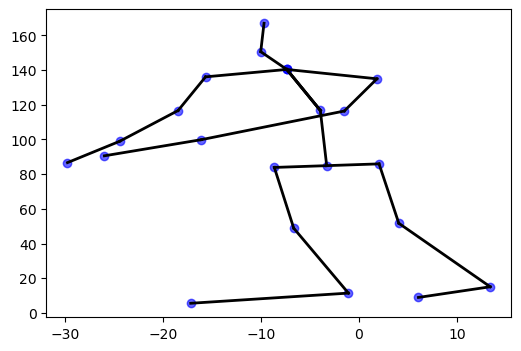

In [23]:
from pymo.parsers import BVHParser
#def fit_tranform(self,X):
       # self.fit(X)
        # return self.transform(X)
parser_2d = BVHParser()
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_Derecha.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10, figsize=(6, 4))

<Axes: >

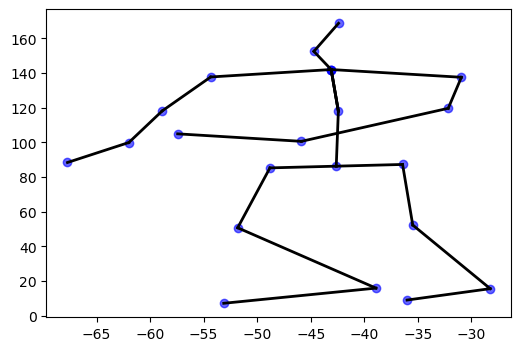

In [24]:
#2.adorozco_Remate_11seg.bvh
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_Remate.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10, figsize=(6, 4))


<Axes: >

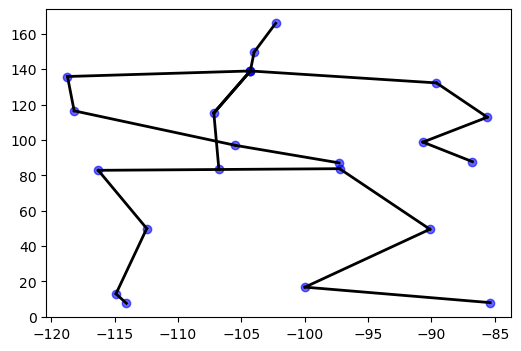

In [25]:
#3.adorozco_Reves_14seg.bvh
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_Reves.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10,figsize=(6, 4))

<Axes: >

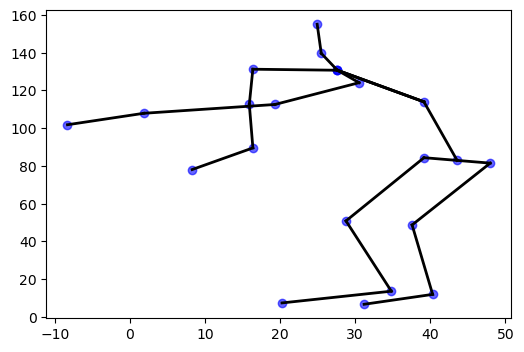

In [27]:
#4.adorozco_Servicio.bvh
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_Servicio.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10, figsize=(6, 4))

<Axes: >

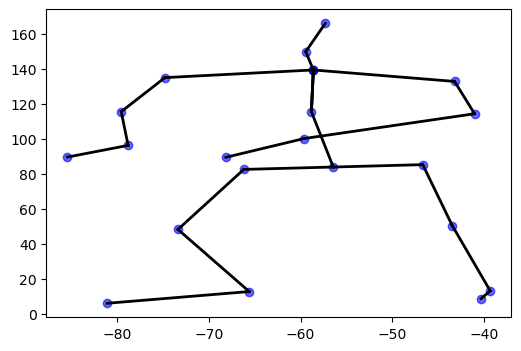

In [28]:
#5.adorozco_VDerecha.bvh
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_VDerecha.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10, figsize=(6, 4))

<Axes: >

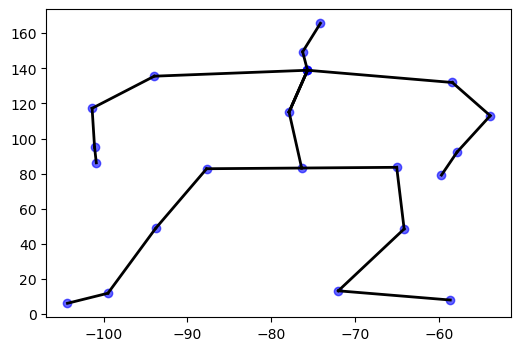

In [29]:
#6.adorozco_VReves.bvh
parsed_data_2d = parser_2d.parse('D:/Escritorio/datos_mocap/01/adorozco_VReves.bvh')
print(parsed_data_2d)
positions_2d = mp.fit_transform([parsed_data_2d])
draw_stickfigure(positions_2d[0], frame=10, figsize=(6, 4))

In [17]:
print(parser_2d)

## CLUSTERING
tiempo que se demore haciendo los cluster. KMEANS - espectral clustering agrupamiento, 100 frames dentro del video. tomar y agrupar con un criterio de agrupamiento tomar los frame mas relevantes, un movimiento de una jugada de tenis tiene unas posiciones claves son las que me dicen la informacion si lo esta haciendo bien o mal.  Expertos vs Amateur

In [18]:
#Clustering positions
start = timeit.timeit()
k=50
dist = SHECCO(k=k)
Xa = np.zeros((len(pos_cent),k,69)) #matriz
ind = np.zeros((len(pos_cent),k))
for i in range(len(pos_cent)):
  Z = np.array(pos_cent[i][0].values)
  Xc,indx = dist.Kmeans_Mocap(Z)
  Xa[i,:,:]= Xc
  ind[i,:] = indx
end = timeit.timeit()
print(end-start)
ind=ind.astype(int)

0.0029808999970555305


## PCA 
cada punto es un frame. resultados de los cluster son los centroides los movimientos más representativos levantar el codo mas informacion que la raqueta ejemplo- algoritmo para reduccion de dimensionalidad en este caso PCA 

trayectoria por cada judagor

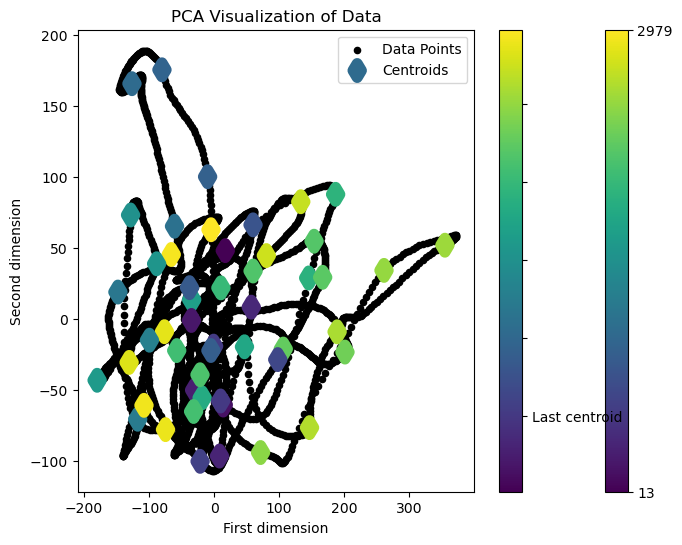

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

v = 1
Z = pos_cent[v][0].values  
pca = PCA(n_components=2) # me diga a PCA cuales son las dimensiones más representativas
x = pca.fit_transform(Z)

# Plot
plt.figure(figsize=(8, 6))  # Ajusta el tamaño de la figura según sea necesario
plt.scatter(x[:, 0], x[:, 1], color='k', s=20, label='Data Points')  # Ajusta el tamaño de los marcadores según sea necesario
plt.scatter(x[ind[v], 0], x[ind[v], 1], marker='d', s=50, linewidths=8, c=ind[v], label='Centroids')
plt.colorbar().set_ticks([np.min(ind[v]), np.max(ind[v])])
plt.colorbar().set_ticklabels(['First centroid', 'Last centroid'])
plt.xlabel('First dimension')
plt.ylabel('Second dimension')
plt.title('PCA Visualization of Data')
# Descomenta el siguiente bloque si deseas agregar etiquetas de los puntos
# for j in range(ind.shape[1]):
#     plt.text(x[ind[v,j], 0], x[ind[v,j], 1], ind[v,j], fontsize=12, color='r')

# Guardar la figura
plt.savefig('throw_pca.pdf', bbox_inches='tight')

# Mostrar la figura
plt.legend()
plt.show()


## We calculate and graph the dissimilarity matrix (calsificacion se hace en espacios de distancias en un espacio de altas dimensiones como un espacio de hilbert) from SHECCO   representar Kernel

In [20]:
#Compute the distances matrix
dist = SHECCO(sigmax=Sigma_x, sigmay=Sigma_y, Ax = k, Ay = k)
D = dist.fit_transform(Xa)

NameError: name 'Sigma_x' is not defined

In [ ]:
import os
from pymo.parsers import BVHParser
from pymo.preprocessing import MocapParameterizer
import numpy as np

# Asegúrate de que list_folder está definido y contiene elementos
list_folder = os.listdir('D:/Escritorio/datos_mocap')  # Asumiendo que list_folder debe contener los nombres de carpetas

p = BVHParser()
print(p)
mp = MocapParameterizer(param_type='position')
pos_cent = {}
directory_path = 'D:/Escritorio/datos_mocap'
print(f"Contents of {directory_path}:")

try:
    contents = os.listdir(directory_path)
    for item in contents:
        print(item)
except PermissionError as e:
    print(f"Permission error for directory {directory_path}: {e}")
except FileNotFoundError as e:
    print(f"Directory not found: {directory_path}: {e}")

print(f"Checking files in list_folder:")
for i in range(len(list_folder)):
    dir_path = os.path.join(directory_path, list_folder[i])
    if os.path.isdir(dir_path):
        for file_name in os.listdir(dir_path):
            file_path = os.path.join(dir_path, file_name)
            if os.path.isfile(file_path):
                try:
                    data_all = [p.parse(file_path)]
                    pos_cent[i] = mp.fit_transform(data_all)
                    print(f"Successfully processed {file_path}")
                except PermissionError as e:
                    print(f"Permission error for {file_path}: {e}")
                except FileNotFoundError as e:
                    print(f"File not found: {file_path}: {e}")
                except Exception as e:
                    print(f"An error occurred while processing {file_path}: {e}")
    else:
        print(f"{dir_path} is not a directory.")

# Normalization with respect to hips positions
for k in range(len(pos_cent)): 
    if k in pos_cent:
        n = pos_cent[k][0].values  # Recorriendo uno a uno los datos y solo traiga la posición 0
        p = np.asarray(n)
        X = p.reshape(n.shape[0], 69, 1)
        Z = np.zeros(X.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i, j, :] = X[i, j, :] - X[i, 0, :]
        Z = Z.reshape(n.shape[0], 69)
        n.iloc[:] = Z[:]
        pos_cent[k][0].values = n
        print(f"Normalized data for key {k}:")
        print(pos_cent[k][0].values)
    else:
        print(f"Key {k} not found in pos_cent")

# Imprime las claves de pos_cent para depuración
print(f"Keys in pos_cent: {list(pos_cent.keys())}")


Normalized data for key 8:
                        Hips_Xposition  Hips_Yposition  Hips_Zposition  \
0 days 00:00:00                    0.0      142.839024       18.404499   
0 days 00:00:00.010000             0.0      142.869751       18.441127   
0 days 00:00:00.020000             0.0      142.867668       18.467182   
0 days 00:00:00.030000             0.0      142.891422       18.492424   
0 days 00:00:00.040000             0.0      142.921104       18.522667   
...                                ...             ...             ...   
0 days 00:00:29.940000             0.0      141.730213       16.570503   
0 days 00:00:29.950000             0.0      141.730213       16.570503   
0 days 00:00:29.960000             0.0      141.730213       16.570503   
0 days 00:00:29.970000             0.0      141.730213       16.570503   
0 days 00:00:29.980000             0.0      141.730213       16.570503   

                        RightHip_Xposition  RightHip_Yposition  \
0 days 00:00:00   

Normalized data for key 10:
                        Hips_Xposition  Hips_Yposition  Hips_Zposition  \
0 days 00:00:00                    0.0      146.483525       37.519284   
0 days 00:00:00.010000             0.0      146.502491       37.649967   
0 days 00:00:00.020000             0.0      146.503487       37.729260   
0 days 00:00:00.030000             0.0      146.536384       37.803958   
0 days 00:00:00.040000             0.0      146.578518       37.887768   
...                                ...             ...             ...   
0 days 00:00:29.950000             0.0      138.199947       35.109051   
0 days 00:00:29.960000             0.0      138.199935       35.109047   
0 days 00:00:29.970000             0.0      138.199935       35.109047   
0 days 00:00:29.980000             0.0      138.199935       35.109047   
0 days 00:00:29.990000             0.0      138.199935       35.109047   

                        RightHip_Xposition  RightHip_Yposition  \
0 days 00:00:00  

Normalized data for key 12:
                        Hips_Xposition  Hips_Yposition  Hips_Zposition  \
0 days 00:00:00                    0.0      194.865395       73.235775   
0 days 00:00:00.010000             0.0      195.010765       73.054577   
0 days 00:00:00.020000             0.0      195.061539       73.262596   
0 days 00:00:00.030000             0.0      195.151222       73.318866   
0 days 00:00:00.040000             0.0      195.257156       73.399513   
...                                ...             ...             ...   
0 days 00:00:29.940000             0.0      158.035576       41.919945   
0 days 00:00:29.950000             0.0      158.035576       41.919948   
0 days 00:00:29.960000             0.0      158.035576       41.919948   
0 days 00:00:29.970000             0.0      158.035576       41.919948   
0 days 00:00:29.980000             0.0      158.035576       41.919948   

                        RightHip_Xposition  RightHip_Yposition  \
0 days 00:00:00  

Normalized data for key 14:
                        Hips_Xposition  Hips_Yposition  Hips_Zposition  \
0 days 00:00:00                    0.0      144.652108       42.641245   
0 days 00:00:00.010000             0.0      144.829757       43.388004   
0 days 00:00:00.020000             0.0      145.032863       44.114795   
0 days 00:00:00.030000             0.0      145.195160       44.654287   
0 days 00:00:00.040000             0.0      145.386920       45.261480   
...                                ...             ...             ...   
0 days 00:00:29.940000             0.0      153.700683       83.796657   
0 days 00:00:29.950000             0.0      153.700683       83.796659   
0 days 00:00:29.960000             0.0      153.700683       83.796659   
0 days 00:00:29.970000             0.0      153.700683       83.796659   
0 days 00:00:29.980000             0.0      153.700683       83.796659   

                        RightHip_Xposition  RightHip_Yposition  \
0 days 00:00:00  

In [ ]:
import os
from pymo.parsers import BVHParser
from pymo.preprocessing import MocapParameterizer
import numpy as np
import matplotlib.pyplot as plt

# Definir la clase SHECCO con el método plot_mocap
class SHECCO:
    def __init__(self):
        self.p = BVHParser()
        self.mp_p = MocapParameterizer(param_type='position')
    
    def plot_mocap(self, Ns, Nv, ind):
        directory_path = 'D:/Escritorio/datos_mocap'
        try:
            list_folder = os.listdir(directory_path)
            print(f"List of folders: {list_folder}")
            folder_path = os.path.join(directory_path, Ns)
            if not os.path.exists(folder_path):
                raise FileNotFoundError(f"Folder {folder_path} does not exist.")
            files_in_folder = os.listdir(folder_path)
            print(f"Files in {folder_path}: {files_in_folder}")
            if Nv >= len(files_in_folder):
                raise IndexError(f"Index Nv={Nv} out of range for files in {folder_path}")
            file_path = os.path.join(folder_path, files_in_folder[Nv])
            if not os.path.isfile(file_path):
                raise FileNotFoundError(f"File {file_path} does not exist.")
            print(f"Processing file: {file_path}")
            data_all = [self.p.parse(file_path)]
            pos_d = self.mp_p.fit_transform(data_all)
            
            # Normalización
            n = pos_d[0].values
            p = np.asarray(n)
            X = p.reshape(n.shape[0], 69, 1)
            Z = np.zeros(X.shape)
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    Z[i, j, :] = X[i, j, :] - X[i, 0, :]
            Z = Z.reshape(n.shape[0], 69)
            n.iloc[:] = Z[:]
            pos_d[0].values = n
            
            # Graficar
            print(f"Shape of n: {n.shape}")
            print(f"Indices: {ind}")
            if n.shape[1] < max(ind) + 1:
                raise IndexError(f"Index out of range for shape {n.shape}")
                
            fig, ax = plt.subplots()
            ax.plot(n[:, ind], label=f'MoCap {Ns} {Nv}')
            ax.set_xlabel('Time')
            ax.set_ylabel('Position')
            ax.legend()
            plt.show()
        
        except Exception as e:
            print(f"An error occurred: {e}")

# Definir ind
ind = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Instanciar la clase y llamar al método plot_mocap
dist = SHECCO()
dist.plot_mocap(Ns='a', Nv=0, ind=ind)
